# Uber Traffic — EDA & Data Preparation

This notebook aggregates raw readings to hourly junction series, fills gaps, engineers features (lags/rolling/calendar), and saves a modeling-ready dataset.

**References (considerations):**
- MoldStud: Role of data science in transportation planning & congestion management — https://moldstud.com/articles/p-the-role-of-data-science-in-transportation-planning-and-traffic-management
- AVUTEC: Traffic data collection methods & implications — https://avutec.com/traffic-data-collection-methods-analysis-and-applications/


In [47]:
# Imports & I/O
import re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

RAW = Path(r"C:\Users\pradi\OneDrive\Desktop\Uber_internship\Component_1\Dataset_Uber Traffic.csv")
OUT = {
    "intermediate_csv": r"C:\Users\pradi\OneDrive\Desktop\Uber_internship\Component_1\traffic_intermediate_hourly.csv",
    "final_csv": r"C:\Users\pradi\OneDrive\Desktop\Uber_internship\Component_1\traffic_aggregated_features.csv",
    "fi_csv": r"C:\Users\pradi\OneDrive\Desktop\Uber_internship\Component_1\feature_importance_randomforest.csv",
}


In [49]:
# Load & detect columns
df = pd.read_csv(RAW)
df.columns = [c.strip().lower().replace(' ','_') for c in df.columns]

def detect_col(cands, cols):
    for cand in cands:
        for col in cols:
            if col == cand or (cand in col):
                return col
    return None

time_col = detect_col(['datetime','date_time','date-time','timestamp','date','time'], df.columns)
junction_col = detect_col(['junction','junction_id','junctionid','sensor_id','site','location_id'], df.columns)
vehicles_col = detect_col(['vehicles','vehicle_count','traffic_volume','volume','count'], df.columns)

(time_col, junction_col, vehicles_col)

('datetime', 'junction', 'vehicles')

In [51]:
# Clean, hourly aggregate, and complete missing hours
df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df[junction_col] = df[junction_col].astype(str)
df[vehicles_col] = pd.to_numeric(df[vehicles_col], errors='coerce')

df = df.dropna(subset=[time_col, vehicles_col, junction_col])
df = df.groupby([junction_col, time_col], as_index=False)[vehicles_col].sum()
df['timestamp_hour'] = df[time_col].dt.floor('h')
agg = df.groupby([junction_col, 'timestamp_hour'], as_index=False)[vehicles_col].sum().rename(columns={vehicles_col:'vehicles'})

def complete_group(g):
    idx = pd.date_range(g['timestamp_hour'].min(), g['timestamp_hour'].max(), freq='h')
    g2 = g.set_index('timestamp_hour').reindex(idx)
    g2.index.name = 'timestamp_hour'
    g2[junction_col] = g[junction_col].iloc[0]
    return g2.reset_index()

completed = (agg.sort_values([junction_col, 'timestamp_hour'])
               .groupby(junction_col, group_keys=False)
               .apply(complete_group)
               .reset_index(drop=True))

def interp_group(g):
    g = g.sort_values('timestamp_hour').set_index('timestamp_hour')
    g['vehicles'] = g['vehicles'].interpolate(method='time').ffill().bfill()
    return g.reset_index()

completed = completed.groupby(junction_col, group_keys=False).apply(interp_group).reset_index(drop=True)
completed.to_csv(OUT['intermediate_csv'], index=False)
completed.head()

C:\Users\pradi\AppData\Local\Temp\ipykernel_27096\3789997636.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
C:\Users\pradi\AppData\Local\Temp\ipykernel_27096\3789997636.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(complete_group)
C:\Users\pradi\AppData\Local\Temp\ipykernel_27096\3789997636.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the

,timestamp_hour,junction,vehicles
0,2015-01-11 00:00:00,1,15.0
1,2015-01-11 01:00:00,1,13.0
2,2015-01-11 02:00:00,1,10.0
3,2015-01-11 03:00:00,1,7.0
4,2015-01-11 04:00:00,1,9.0


In [53]:
# Feature engineering (lags, rolling, calendar)
feat = completed.copy()
feat['year'] = feat['timestamp_hour'].dt.year
feat['month'] = feat['timestamp_hour'].dt.month
feat['day'] = feat['timestamp_hour'].dt.day
feat['hour'] = feat['timestamp_hour'].dt.hour
feat['dayofweek'] = feat['timestamp_hour'].dt.dayofweek
feat['is_weekend'] = (feat['dayofweek'] >= 5).astype(int)
feat['is_peak_hour'] = feat['hour'].isin([7,8,9,17,18,19,20]).astype(int)
feat['is_special_event'] = 0

def add_lags_rolls(g):
    g = g.sort_values('timestamp_hour').copy()
    for L in [1,24,168]:
        g[f'lag_{L}h'] = g['vehicles'].shift(L)
    g['roll_mean_3h'] = g['vehicles'].rolling(3, min_periods=1).mean()
    g['roll_mean_24h'] = g['vehicles'].rolling(24, min_periods=1).mean()
    g['roll_std_24h'] = g['vehicles'].rolling(24, min_periods=2).std()
    g['roll_max_24h'] = g['vehicles'].rolling(24, min_periods=1).max()
    g['ewm_12h'] = g['vehicles'].ewm(span=12, adjust=False).mean()
    return g

feat = feat.groupby(junction_col, group_keys=False).apply(add_lags_rolls)
feat = feat.dropna(subset=['lag_1h','lag_24h','lag_168h']).reset_index(drop=True)

exclude = {junction_col, 'timestamp_hour', 'vehicles'}
num_cols = [c for c in feat.columns if c not in exclude and pd.api.types.is_numeric_dtype(feat[c])]
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(feat[num_cols]), columns=[f'z_{c}' for c in num_cols])
feat_scaled = pd.concat([feat.reset_index(drop=True), scaled_df.reset_index(drop=True)], axis=1)

feat_scaled.to_csv(OUT['final_csv'], index=False)
feat_scaled.head()

C:\Users\pradi\AppData\Local\Temp\ipykernel_27096\876539363.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feat = feat.groupby(junction_col, group_keys=False).apply(add_lags_rolls)


,timestamp_hour,junction,vehicles,year,month,day,hour,dayofweek,is_weekend,is_peak_hour,...,z_is_peak_hour,z_is_special_event,z_lag_1h,z_lag_24h,z_lag_168h,z_roll_mean_3h,z_roll_mean_24h,z_roll_std_24h,z_roll_max_24h,z_ewm_12h
0,2015-01-18 00:00:00,1,23.916786,2015,1,18,0,6,1,0,...,-0.641689,0.0,0.138302,0.159332,-0.300678,0.139515,0.158280,-0.729294,-0.181386,0.149842
1,2015-01-18 01:00:00,1,23.899570,2015,1,18,1,6,1,0,...,-0.641689,0.0,0.137448,0.158477,-0.400388,0.138654,0.157367,-0.729294,-0.182055,0.148944
2,2015-01-18 02:00:00,1,23.882353,2015,1,18,2,6,1,0,...,-0.641689,0.0,0.136594,0.157622,-0.549954,0.137792,0.156454,-0.729294,-0.182724,0.148045
3,2015-01-18 03:00:00,1,23.865136,2015,1,18,3,6,1,0,...,-0.641689,0.0,0.135740,0.156766,-0.699519,0.136931,0.155540,-0.729294,-0.183393,0.147147
4,2015-01-18 04:00:00,1,23.847920,2015,1,18,4,6,1,0,...,-0.641689,0.0,0.134886,0.155911,-0.599809,0.136070,0.154627,-0.729294,-0.184062,0.146249


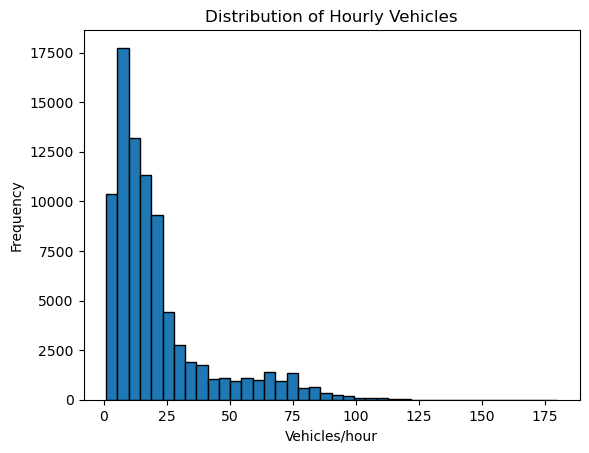

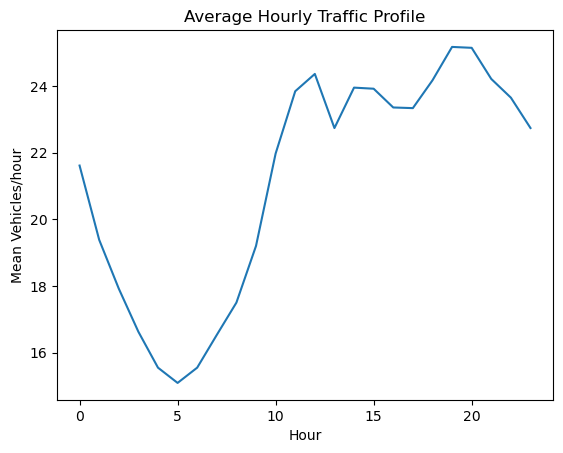

<Figure size 640x480 with 0 Axes>

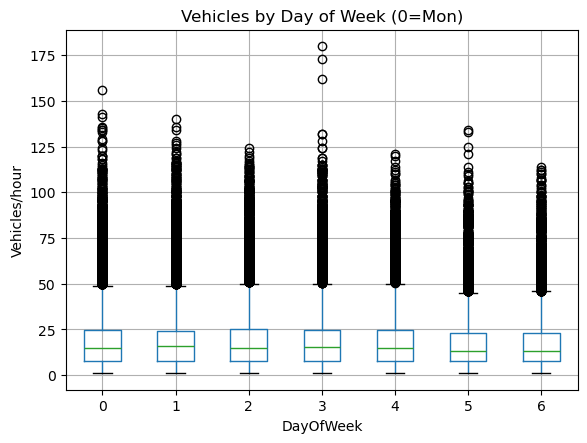

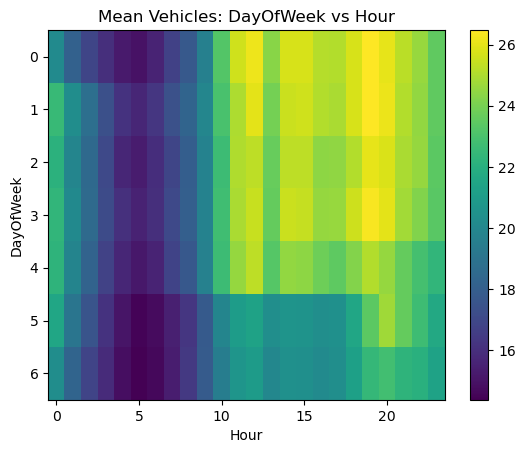

In [55]:
# Quick visuals (single-plot, matplotlib defaults)
plt.figure(); plt.hist(feat_scaled['vehicles'].dropna(), bins=40, edgecolor='black'); plt.title('Distribution of Hourly Vehicles'); plt.xlabel('Vehicles/hour'); plt.ylabel('Frequency'); plt.show()

hourly_profile = feat_scaled.groupby('hour')['vehicles'].mean()
plt.figure(); hourly_profile.plot(kind='line'); plt.title('Average Hourly Traffic Profile'); plt.xlabel('Hour'); plt.ylabel('Mean Vehicles/hour'); plt.show()

plt.figure(); feat_scaled.boxplot(column='vehicles', by='dayofweek'); plt.suptitle(''); plt.title('Vehicles by Day of Week (0=Mon)'); plt.xlabel('DayOfWeek'); plt.ylabel('Vehicles/hour'); plt.show()

pivot = feat_scaled.pivot_table(index='dayofweek', columns='hour', values='vehicles', aggfunc='mean')
plt.figure(); plt.imshow(pivot.values, aspect='auto'); plt.title('Mean Vehicles: DayOfWeek vs Hour'); plt.xlabel('Hour'); plt.ylabel('DayOfWeek'); plt.colorbar(); plt.show()


In [57]:
# RandomForest-based feature importance (time-aware, no leakage)
from sklearn.ensemble import RandomForestRegressor

# Where to save
out_path = OUT['fi_csv'] if 'OUT' in globals() and isinstance(OUT, dict) and 'fi_csv' in OUT \
    else 'feature_importance_randomforest.csv'

# Candidate features (use only ones present in the frame)
candidate_X = [
    "hour","dayofweek","month","year",
    "is_weekend","is_peak_hour","is_special_event",
    "lag_1h","lag_24h","lag_168h",
    "roll_mean_3h","roll_mean_24h","roll_std_24h","roll_max_24h",
    "ewm_12h"
]
X_cols = [c for c in candidate_X if c in feat_scaled.columns]
assert len(X_cols) > 0, f"No expected features found in dataframe. Columns present: {list(feat_scaled.columns)[:40]}"

# Time-aware split to avoid leakage
assert 'timestamp_hour' in feat_scaled.columns, "timestamp_hour column missing."
time_cut = feat_scaled['timestamp_hour'].quantile(0.85)
train = feat_scaled.loc[feat_scaled['timestamp_hour'] <= time_cut].copy()

# Prepare training matrices
X = train[X_cols]
y = train['vehicles']

# RandomForest parameters (match the “full, deeper” profile)
rf = RandomForestRegressor(
    n_estimators=36,      # adjust to 100–300 if you want even more stability
    max_depth=20,
    min_samples_leaf=5,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
rf.fit(X, y)

# Build and save importance table
fi = (
    pd.Series(rf.feature_importances_, index=X_cols)
      .sort_values(ascending=False)
      .rename("importance")
      .reset_index()
      .rename(columns={"index": "feature"})
)

fi.to_csv(out_path, index=False)
fi.head(15)


,feature,importance
0,lag_1h,0.222594
1,roll_mean_3h,0.211687
2,roll_max_24h,0.137680
3,ewm_12h,0.132508
4,lag_24h,0.113086
5,roll_mean_24h,0.105358
6,lag_168h,0.043095
7,roll_std_24h,0.016838
8,hour,0.010605
9,year,0.002862
